In [1]:
import sys
import os

current_dir = os.getcwd()

project_root = os.path.abspath(os.path.join(os.path.dirname(current_dir), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

import pinns

# For cleaner output.
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
import torch
import torch.nn as nn

import matplotlib.pyplot as plt

We are going to solve Damped Harmonic Oscillator problem using Kolmogorov-Arnold Network. Our setting will be the same as in default DHO solution method. As you will see, it differs not that much from FF training (thanks to authors of pykan for their effort in providing KAN as pytorch module). We will also compare many of KAN versions and see which of them perform better.

Our library provides easy-to-use wrapper for pykan library, but you always kan define your own network.

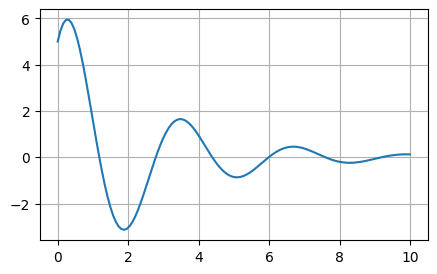

In [3]:
import numpy as np
from scipy.integrate import solve_ivp

def dho(t, y, zeta, omega):
    x, v = y
    dxdt = v
    dvdt = -2 * zeta * omega * v - omega**2 * x
    return [dxdt, dvdt]

T = 10              # We need to fix some computational domain.
zeta, omega = 0.2, 2.0    # Parameters that yields interesting function.
x0, v0 = 5.0, 7.0   # Initial values may be arbitrary.

t = torch.linspace(0, T, 128)
solution = solve_ivp(dho, (0, T), (x0, v0), t_eval=t, args=(zeta, omega)).y[0]

fig = plt.figure(figsize=(5, 3))
plt.plot(t, solution)
plt.grid()
plt.show()

In [4]:
from pinns.samplers import ConstantSampler, RandomSampler

# Constraints (training data) sampler must return tuple (points, values).
constraints_sampler = ConstantSampler((
    torch.tensor([[0.]], requires_grad=True),
    torch.tensor([x0, v0])
))

# Collocation sampler must return just tensor of shape [num_pts, coords].
domain = {'t': [0, T]}
collocation_sampler = RandomSampler(domain, 256, return_dict=False)

# Test points sampler must return tuple (points, values) of shape [num_pts, coords].
test_points_sampler = ConstantSampler(
    (t.reshape(-1, 1), solution.reshape(-1, 1))
    )

In [5]:
from pinns.derivatives import Derivative

d = Derivative(method = 'autograd')

def loss(
    cstr_pts, cstr_pred, cstr_vals,
    coll_pts, coll_pred,
    zeta = 0.2, omega = 2.0
    ):
    
    def init_loss(x0, t0):
        v0 = d(x0, t0)
        return torch.mean(torch.square(torch.hstack([x0, v0]) - cstr_vals))

    def ode_loss(x, t):
        v, a = d(x, t, orders = [1, 2])
        v = v[~torch.isnan(v)] # We do this to protect some of KAN 
        a = a[~torch.isnan(a)] # variations from falling into NaN loss
        return torch.mean(torch.square(a + 2 * zeta * omega * v + omega**2 * x))
    
    losses = (
        init_loss(cstr_pred, cstr_pts),
        ode_loss(coll_pred, coll_pts)
    )
    
    return losses

Here is simple version of training:

In [24]:
from pinns import Trainer
from pinns.models import KAN
from pinns.optimizers import Adam

# pinn = KAN([1, 5, 1], grid = 5)
pinn = KAN([1, 10, 1], type = 'efficient', grid_size = 15)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

trainer.train(
    num_iters=100,
    optimizers=[(0, adam)],
    validate_every=1
)

Model has 192 trainable parameters.


  0%|          | 0/1000 [00:00<?, ?it/s]

For classic KAN, we can employ grid refining method, as described in pykan: at some point we change number of grid points and continue training of the  same model. Interestingly, this method works not as for classic regression  problems (due to the peculiarities of PINNs training), but as described in  our paper it somewhat helps to decrease approximation error.

Here is how to do it:

In [ ]:
# (grid size, how much iters)
gridit = [(10, 50), (15, 50)]

pinn = KAN([1, 5, 1], grid = 5)
print(f'Model has {pinn.count_parameters()} trainable parameters.')

adam = Adam(pinn, lr = 1e-2)

trainer = Trainer(
    loss,
    pinn,
    constraints_sampler,
    collocation_sampler,
    loss_coefs=[0.8, 0.2],    # Coefficients are very important.
    test_points_sampler=test_points_sampler
)

for i, (grid, it) in enumerate(gridit):
    
    pts, _ = test_points_sampler()

    pinn = KAN([1, 5, 1], grid = grid).initialize_from_another_model(trainer.model, pts)
    trainer.model = pinn
        
    adam = Adam(pinn, lr = 1e-2)
    
    # trainer.iter += 1
    trainer.train(
        num_iters = it,
        optimizers=[(0, adam)],
        validate_every=1,
        show_progress=True
    )

In [ ]:
from pinns.errors import l2
trainer.evaluate(l2)

In [ ]:
# pinn.model = torch.load('./very_good_model_dont_delete.pt')

fig, axs = plt.subplots(1, 2, figsize=(10, 3))

axs[0].plot(trainer.loss_history, label='Loss')
axs[0].plot(trainer.error_history, label='L2')
axs[0].grid()
axs[0].set_yscale('log')
axs[0].legend()

preds = pinn.predict(t.reshape(-1, 1))
axs[1].plot(t, solution, label='Solution')
axs[1].plot(t, preds.detach(), label='Predicts', linestyle=':')
axs[1].grid()
axs[1].legend()

plt.show()

And we kan visualize activation functions of our trained network, if we use default pykan version of model.

In [ ]:
trainer.model.model.plot()